# Rabbits I

Copyright 2017 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)


In [3]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

This notebook develops a simple growth model and uses it to demonstrate a parameter sweep.

The system we'll model is a rabbit farm.  Suppose you start with an initial population of rabbits and let them breed.  For simplicity, we'll assume that all rabbits are on the same breeding cycle, and we'll measure time in "seasons", where a season is the reproductive time of a rabbit.

If we provide all the food, space and other resources a rabbit might need, we expect the number of new rabbits each season to be proportional to the current population, controlled by a parameter, `birth_rate`, that represents the number of new rabbits per existing rabbit, per season.  As a starting place, I'll assume `birth_rate = 0.9`.

Sadly, during each season, some proportion of the rabbits die.  In a detailed model, we might keep track of each rabbit's age, because the chance of dying is probably highest for young and old rabbits, and lowest in between.  But to start, we'll model the death process with a single parameter, `death_rate`, that represent the number
of deaths per rabbit per season.   As a starting place, I'll assume `death_rate = 0.5`.

Here's a system object that contains these parameters as well as:

* The initial population, `p0`,
* The initial time, `t0`, and
* The duration of the simulation, `t_end`, measured in seasons.

In [4]:
system = dict(t0 = 0, 
            t_end = 10,
            p0 = 10,
            birth_rate = 0.9,
            death_rate = 0.5)

system

{'t0': 0, 't_end': 10, 'p0': 10, 'birth_rate': 0.9, 'death_rate': 0.5}

Here's a version of run_simulation with both births and deaths proportional to the current population.

In [7]:
def run_simulation(system):
    """Runs a proportional growth model.
    
    Adds Series to `system` as `results`.
    
    system: System object with t0, t_end, p0,
            birth_rate and death_rate
    """
    results = pd.Series([],dtype=object)
    results[system['t0']] = system['p0']
    num_seasons = system['t_end'] - system['t0'] + 1
    
    for t in linspace(system['t0'], system['t_end'],num_seasons):
        births = system['birth_rate'] * results[t]
        deaths = system['death_rate'] * results[t]
        results[t+1] = results[t] + births - deaths
    system['results'] = results

Now we can run the simulation and display the results:

In [8]:
run_simulation(system)
system['results']

0      10.000000
1      14.000000
2      19.600000
3      27.440000
4      38.416000
5      53.782400
6      75.295360
7     105.413504
8     147.578906
9     206.610468
10    289.254655
11    404.956517
dtype: float64

The following function plots the results.

In [9]:
def plot_results(system, title=None):
    """Plot the estimates and the model.
    
    system: System object with `results`
    """

    system['results'].plot(label='rabbits',xlabel='Season', 
             ylabel='Rabbit population',legend=True,
             title=title)

And here's how we call it.

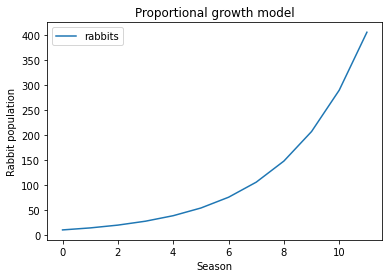

In [10]:
plot_results(system, title='Proportional growth model')

Let's suppose our goal is to maximize the number of rabbits, so the metric we care about is the final population.  We can extract it from the results like this:

In [11]:
def final_population(system):
    results = system['results']
    t_end = results.index[-1]
    return results[t_end]

And call it like this:

In [12]:
final_population(system)

404.9565169664003

To explore the effect of the parameters on the results, we'll define `make_system`, which takes the system parameters as function parameters(!) and returns a `System` object:

In [13]:
def make_system(birth_rate, death_rate):
    
    system = dict(t0 = 0, 
                    t_end = 10,
                    p0 = 10,
                    birth_rate = birth_rate,
                    death_rate = death_rate)
    return system

Now we can make a `System`, run a simulation, and extract a metric:

In [14]:
system = make_system(0.9,0.5)
run_simulation(system)
final_population(system)

404.9565169664003

To see the relationship between `birth_rate` and final population, we'll define `sweep_birth_rate`:

In [15]:
def sweep_birth_rate(birth_rates, death_rate):
    sweep = pd.Series([],dtype=object)
    
    for birth_rate in birth_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        sweep[birth_rate] = final_population(system)
    sweep.plot(xlabel='Births per rabbit per season',
               ylabel='Final population',
               title= 'Final population as function of birth rate')

The first parameter of `sweep_birth_rate` is supposed to be an array; we can use `linspace` to make one.

In [16]:
birth_rates = linspace(0, 1, 21)
birth_rates

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

Now we can call `sweep_birth_rate`.

The resulting figure shows the final population for a range of values of `birth_rate`.

Confusingly, the results from a parameter sweep sometimes resemble a time series.  It is very important to remember the difference.  One way to avoid confusion: LABEL THE AXES.

In the following figure, the x-axis is `birth_rate`, NOT TIME.

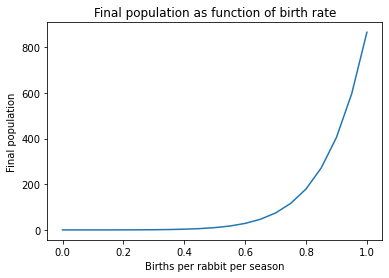

In [17]:
birth_rates = linspace(0, 1, 21)
sweep_birth_rate(birth_rates,0.5)

The code to sweep the death rate is similar.

In [18]:
def sweep_death_rate(death_rates, birth_rate):  
    sweep = pd.Series([],dtype=object)
    
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        sweep[death_rate] = final_population(system)
    sweep.plot(xlabel='Deaths per rabbit per season',
               ylabel='Final population',color='C4',
               title= 'Final population as function of death rate')

And here are the results.  Again, the x-axis is `death_rate`, NOT TIME.

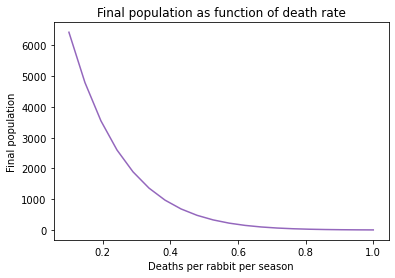

In [19]:
death_rates = linspace(0.1, 1, 20)
sweep_death_rate(death_rates,0.9)

In the previous sweeps, we hold one parameter constant and sweep the other.

You can also sweep more than one variable at a time, and plot multiple lines on a single axis.

To keep the figure from getting too cluttered, I'll reduce the number of values in `birth_rates`:

In [20]:
birth_rates = linspace(0.4, 1, 4)
birth_rates

array([0.4, 0.6, 0.8, 1. ])

By putting one for loop inside another, we can enumerate all pairs of values.

The results show 4 lines, one for each value of `birth_rate`.

(I did not plot the lines between the data points because of a limitation in `plot`.)

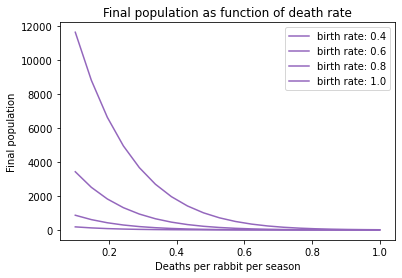

In [21]:
for birth_rate in birth_rates:
    sweep = pd.Series([],dtype=object)
    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        sweep[death_rate] = final_population(system)
    label = 'birth rate: ' + str(birth_rate)
    sweep.plot(xlabel='Deaths per rabbit per season',
               ylabel='Final population',color='C4',
               title= 'Final population as function of death rate',
              legend=True,label=label)
        


If you suspect that the results depend on the difference between `birth_rate` and `death_rate`, you could run the same loop, plotting the "net birth rate" on the x axis.

If you are right, the results will fall on a single curve, which means that knowing the difference is sufficient to predict the outcome; you don't actually have to know the two parameters separately.

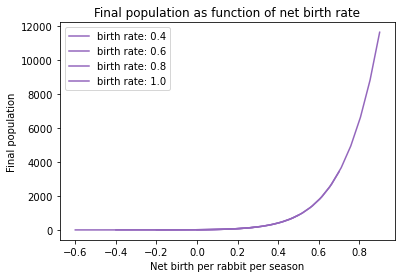

In [22]:
for birth_rate in birth_rates:
    sweep = pd.Series([],dtype=object)

    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        net_birth_rate = birth_rate - death_rate
        sweep[net_birth_rate] = final_population(system)
    label = 'birth rate: ' + str(birth_rate)
    sweep.plot(xlabel='Net birth per rabbit per season',
               ylabel='Final population',color='C4',
               title= 'Final population as function of net birth rate',
              legend=True,label=label)

On the other hand, if you guess that the results depend on the ratio of the parameters, rather than the difference, you could check by plotting the ratio on the x axis.

If the results don't fall on a single curve, that suggests that the ratio alone is not sufficient to predict the outcome. 

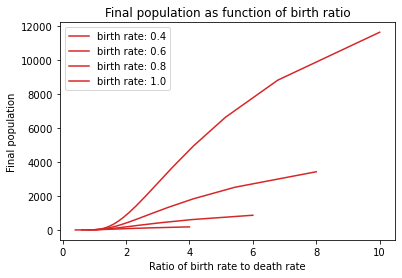

In [23]:
for birth_rate in birth_rates:
    sweep = pd.Series([],dtype=object)

    for death_rate in death_rates:
        system = make_system(birth_rate=birth_rate,
                             death_rate=death_rate)
        run_simulation(system)
        birth_ratio = birth_rate/death_rate
        sweep[birth_ratio] = final_population(system)
    label = 'birth rate: ' + str(birth_rate)
    sweep.plot(xlabel='Ratio of birth rate to death rate',
               ylabel='Final population',color='C3',
               title= 'Final population as function of birth ratio',
              legend=True,label=label)